In [1]:
import cv2
import tempfile, os
from general_utils.model.yolo.yolo_predictor import YoloPredictor
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import tempfile
from random import randint
import math
import pandas as pd


# leyendo dataset

In [2]:
def random_color():
    r = randint(0, 255)
    g = randint(0, 255)
    b = randint(0, 255)    
    return (r, g, b)

def xml2list(xml_path):
    #print("xml to csv {}".format(xml_path))
    xml_list = []
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        for member in root.findall('object'):
            tag = str(member.findall('name')[0].text)
            xmin = int(member.findall('bndbox')[0].findall('xmin')[0].text)
            ymin = int(member.findall('bndbox')[0].findall('ymin')[0].text)
            xmax = int(member.findall('bndbox')[0].findall('xmax')[0].text)
            ymax = int(member.findall('bndbox')[0].findall('ymax')[0].text)

            xml_list.append({
                tag: (xmin, ymin, xmax, ymax)
            })      
    except Exception as e:
        print('xml conversion failed:{}'.format(e))
    return xml_list

In [3]:
# serverstorage/Almacenamiento I+D+i/Proyectos/04.01.02 Proyectos en Curso/IA/20220927 FD-Image/20221111 Tracking-Vehicles/data/8/2023-03-24 10-02-19
FOLDER = "/serverstorage/2023-03-24 10-02-19"


images = []
xml = []
for file in os.listdir(FOLDER):
    name, extension = file.split(".")
    if extension.find("xml")>=0:
        xml.append(name)
    else:
        images.append(file)

In [4]:
images.sort()

In [5]:
images[:5], xml[:5]

(['2023-03-24 10-02-19 001.jpg',
  '2023-03-24 10-02-19 002.jpg',
  '2023-03-24 10-02-19 003.jpg',
  '2023-03-24 10-02-19 004.jpg',
  '2023-03-24 10-02-19 005.jpg'],
 ['2023-03-24 10-02-19 121',
  '2023-03-24 10-02-19 152',
  '2023-03-24 10-02-19 039',
  '2023-03-24 10-02-19 032',
  '2023-03-24 10-02-19 118'])

In [6]:
TIME_PROPOSE = 1 # second

# leyendo las imagenes y cargandolas en memoria

In [7]:
CAM_FILTER = "01"

In [8]:
conteo = 0

all_images = []
all_names = []
vehicles = {}

for i, image in enumerate(images):

    image = os.path.join(FOLDER, image)
    file, extension = image.split(".")
    
    image = cv2.imread(image)    
    tags = None
    try:  
        xml_to_search = file.split(os.sep)[-1]
        id_xml = xml.index(xml_to_search)   
        file_xml = os.path.join(FOLDER, xml[id_xml]+".xml")
        tags = xml2list(file_xml)   
    except Exception as e:        
        pass

    if tags:
        #print("SI:", i)
        for tag in tags:
            for k, (xmin, ymin, xmax, ymax) in tag.items():
                name_key = k.split("_")[0]
                name_cam = k.split("_")[1]

                if CAM_FILTER == name_cam:
                
                    color = (255, 0, 0)  # Blue color in BGR                
                    thickness = 2  # Line thickness of 2 px
                    image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, thickness)
        
                    center_coordinates = xmin + int((xmax-xmin)/2), ymin + int((ymax-ymin)/2)
                    radius = 20
                    color = (0, 0, 255)
                    thickness = 2
                    image = cv2.circle(image, center_coordinates, radius, color, thickness)
        
                    fontScale = 1
                    color = (255, 0, 0)
                    thickness = 2
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    image = cv2.putText(image, name_key, (xmin, ymin), font, fontScale, color, thickness, cv2.LINE_AA)
        
                    bbox_area = ( xmax - xmin ) * ( ymax - ymin )
        
                    if name_key not in vehicles:
                        vehicles[name_key] = []
                        all_names.append(name_key)
                        
                    vehicles[name_key].append(
                        {
                            "center": center_coordinates,
                            "area": bbox_area,
                            "frame_id": i,
                            "cam": name_cam,
                            "file": file
                        }
                    )
        
                    all_names.append(name_key)
    else:
        #print("NO:", i)
        pass

    all_images.append(image)

height,width,layers=all_images[1].shape

# Analizando el compilado de las imagenes

## export complete video

In [9]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 

In [10]:
video = cv2.VideoWriter("/serverstorage/output.avi", fourcc, 1, (width,height))

for i, image in enumerate(all_images):
    video.write(image)
    
cv2.destroyAllWindows()
video.release()

## export video for specific car

In [11]:
name_car = all_names[0]

name_car, vehicles[name_car]

('0001',
 [{'center': (1296, 192),
   'area': 1440,
   'frame_id': 10,
   'cam': '01',
   'file': '/serverstorage/2023-03-24 10-02-19/2023-03-24 10-02-19 011'},
  {'center': (1271, 215),
   'area': 1920,
   'frame_id': 11,
   'cam': '01',
   'file': '/serverstorage/2023-03-24 10-02-19/2023-03-24 10-02-19 012'},
  {'center': (1268, 215),
   'area': 2226,
   'frame_id': 12,
   'cam': '01',
   'file': '/serverstorage/2023-03-24 10-02-19/2023-03-24 10-02-19 013'}])

In [12]:
from operator import itemgetter
newlist = sorted(vehicles[name_car], key=itemgetter('frame_id')) 

video = cv2.VideoWriter(f"/serverstorage/{name_car}.avi", fourcc, 1, (width,height))
for d in newlist:
    id = d['frame_id']
    image = all_images[id]
    video.write(image)
    
cv2.destroyAllWindows()
video.release()

# prediciendo la proxima posicion del vehiculo de acuerdo a su trayectoria

In [151]:
def hallar_valor_futuro(original_data):
    (p, d, q) = (1, 1, 2)
    
    if len(original_data) > 2: 
        all_x = []
        all_y = []
        for x, y in original_data:
            all_x.append(x)
            all_y.append(y)
        
        
        model_x = ARIMA(all_x, order=(p, d, q))
        model_y = ARIMA(all_y, order=(p, d, q))
        
        model_x_fit = model_x.fit()
        model_y_fit = model_y.fit()
        
        future_steps = 2  # Número de pasos futuros para predecir
        forecast_x = model_x_fit.get_forecast(steps=future_steps)
        forecast_y = model_y_fit.get_forecast(steps=future_steps)
        
        # Obtener los valores predichos y los intervalos de confianza
        predicted_values_x = forecast_x.predicted_mean
        confidence_intervals_x = forecast_x.conf_int()
        
        predicted_values_y = forecast_y.predicted_mean
        confidence_intervals_y = forecast_y.conf_int()
        
        predicted_values_x = [ int(a) for a in  list(predicted_values_x)]
        predicted_values_y = [ int(a) for a in  list(predicted_values_y)]
        
        
        predictions = list(zip(list(predicted_values_x), list(predicted_values_y)))
        
        #list(zip(all_x, all_y))
        return predictions
    print("NO hay suficientes datos para hallar un valor futuro")

In [159]:
estado = ["O", "P"]

def graficar_original_prediccion(original_data, predictions):
    if not predictions:
        return "No se puede graficar sin predicciones"
    
    fondo = 255*np.ones([height, width, 3], np.uint8)
    
    radius = 5
    thickness = 5
    
    for k, coordinates in enumerate([
        original_data ,
        predictions
    ]):
        color = random_color()
        for i, coordinate in enumerate(coordinates):
            fondo = cv2.circle(fondo, coordinate, radius, color, thickness)
        
        for i, coordinate in enumerate(coordinates[:-1]):
            # print(feature["frame_id"], vehicles[name_car][i+1]["frame_id"])
            desde = coordinate
            hasta = coordinates[i+1]
            fondo = cv2.line(fondo, desde, hasta , color, thickness )

        fontScale = 1
        font = cv2.FONT_HERSHEY_SIMPLEX
        fondo = cv2.putText(fondo, estado[k], coordinates[-1], font, fontScale, color, thickness, cv2.LINE_AA)
    
    # unir original y prediccion en el grafico
    desde = original_data[-1]
    hasta = predictions[0]
    fondo = cv2.line(fondo, desde, hasta , color, thickness )
    
    plt.figure(figsize=(20,8))
    plt.title('Movimientos actuales del vehiculo')
    plt.imshow(fondo)
    plt.show()

In [148]:
nombres = all_names
nombres = list(set(all_names))
len(nombres)

30

## graficar original y prediccion

In [155]:
name_car = nombres[15]

original_data = [ id["center"] for id in vehicles[name_car] ]

predictions = hallar_valor_futuro(original_data)
original_data, predictions

([(1279, 210), (1279, 210), (1241, 246), (1172, 311), (1036, 466)],
 [(886, 632), (731, 804)])

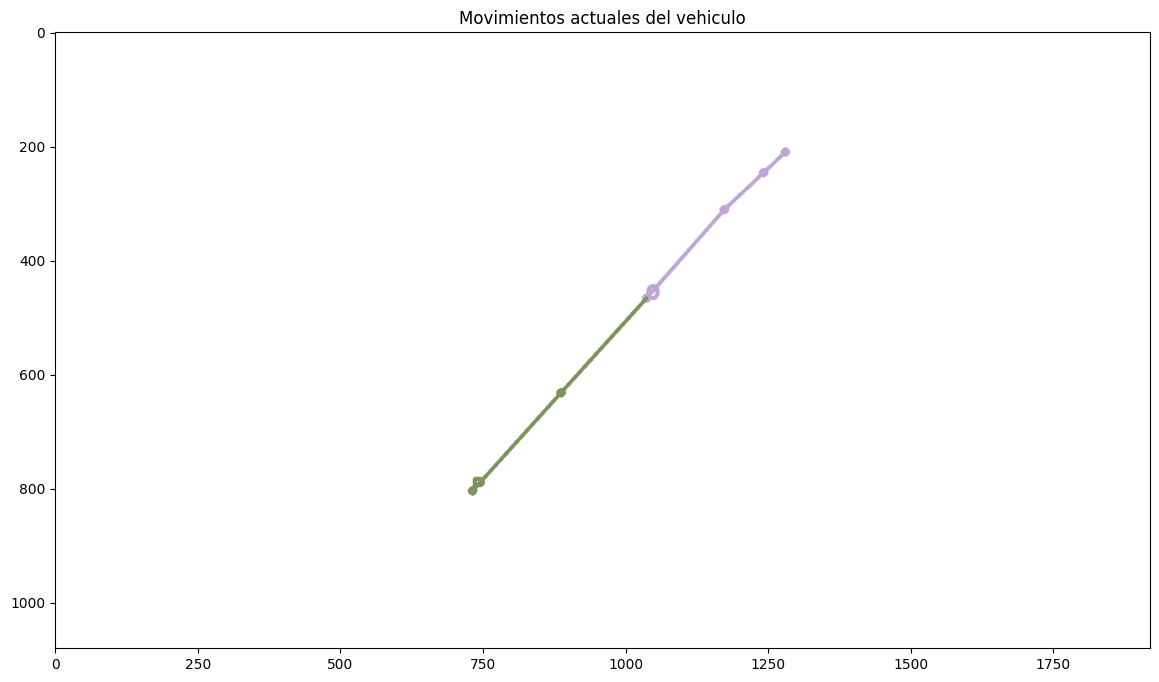

In [161]:
graficar_original_prediccion(original_data, predictions)

# searching directions for vehicles

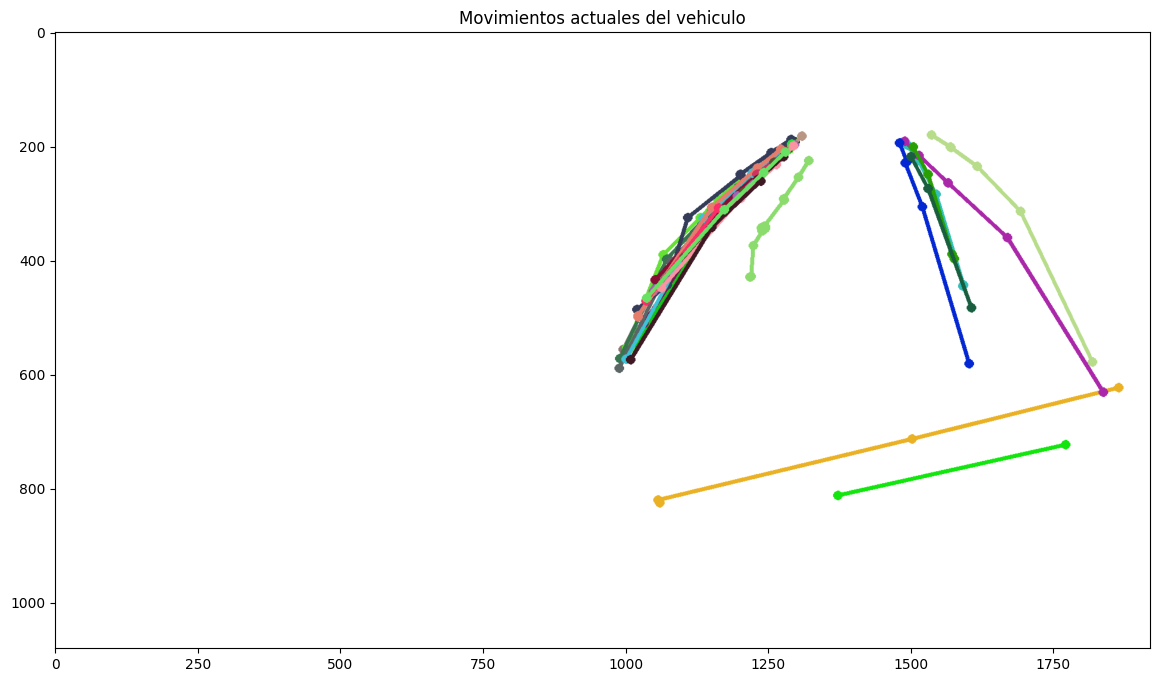

[(1605, 483), (1529, 274), (1499, 218)]

In [163]:
directions = {
    "up": 0, 
    "down": 1,
}

fondo = 255*np.ones([height, width, 3], np.uint8)

radius = 5
thickness = 5

all_center = []
all_areas = []
all_directions = []
all_distance = []

for name_car in all_names:
    
    color = random_color()

    # order centers by coordinates
    coordinates_noOrder = [ id["center"] for id in vehicles[name_car] ]
    # order first position 1 and after by postiion 0
    coordinates = sorted(coordinates_noOrder , key=lambda k: [k[1], k[0]]) 

    area = [ id["area"] for id in vehicles[name_car] ]
    
    for i, coordinate in enumerate(coordinates):
        fondo = cv2.circle(fondo, coordinate, radius, color, thickness)
        all_center.append(coordinate)
        all_areas.append(area[i])

    for i, coordinate in enumerate(coordinates[:-1]):
        # print(feature["frame_id"], vehicles[name_car][i+1]["frame_id"])
        desde = coordinate
        hasta = coordinates[i+1]
        fondo = cv2.line(fondo, desde, hasta , color, thickness )

        distance = np.sqrt((hasta[0]-desde[0])**2 + (hasta[1]-desde[1])**2)
        all_distance.append(distance)
        
        #angle = math.atan2(y, x) * (180.0 / math.pi)
    

    direction = directions["up"]

    fontScale = 1
    font = cv2.FONT_HERSHEY_SIMPLEX
    #fondo = cv2.putText(fondo, str(direction), coordinates[-1], font, fontScale, color, thickness, cv2.LINE_AA)
    
    for _ in coordinates:
        all_directions.append(direction)
    #break

plt.figure(figsize=(20,8))
plt.title('Movimientos actuales del vehiculo')
plt.imshow(fondo)
plt.show()

cv2.imwrite("/serverstorage/Movimientos_actuales_del_vehiculo.jpg", fondo)

coordinates_noOrder

# hallando la dispersion

In [160]:
len(all_center), len(all_areas), len(all_distance), len(all_directions)

(4072, 4072, 3827, 4072)

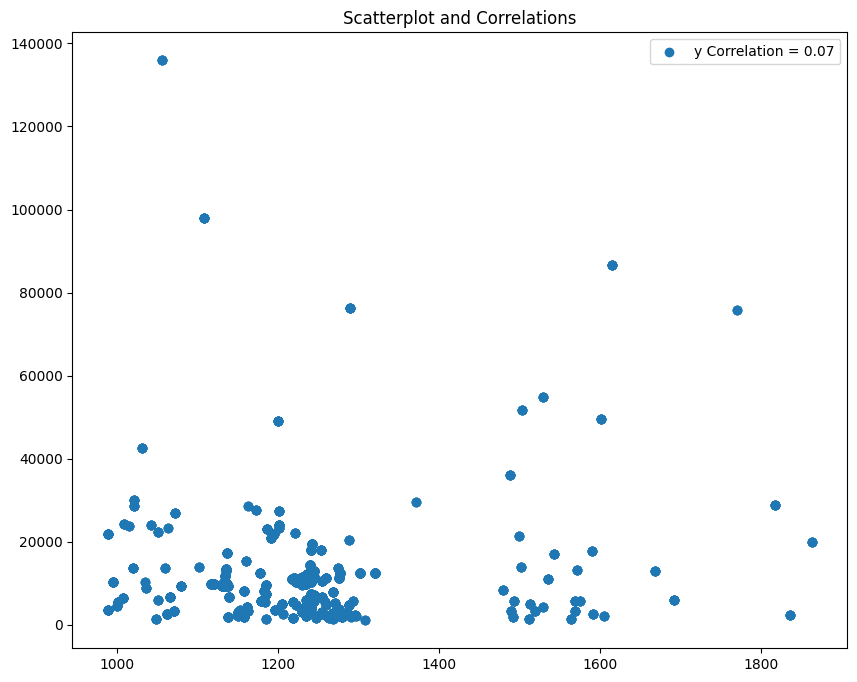

In [88]:
x = [d[0] for d in all_center]
y = [d[0] for d in all_center]
y = all_areas

plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.scatter(x, y, label=f'y Correlation = {np.round(np.corrcoef(x,y)[0,1], 2)}')
plt.title('Scatterplot and Correlations')
plt.legend()
plt.show()

In [179]:
data = list(zip(list(all_center), all_directions))

data = []
for i, (x, y) in enumerate(all_center):
    data.append((x, y, all_directions[i], all_areas[i]))

data[0]

(1288, 201, 0, 4680)

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explic

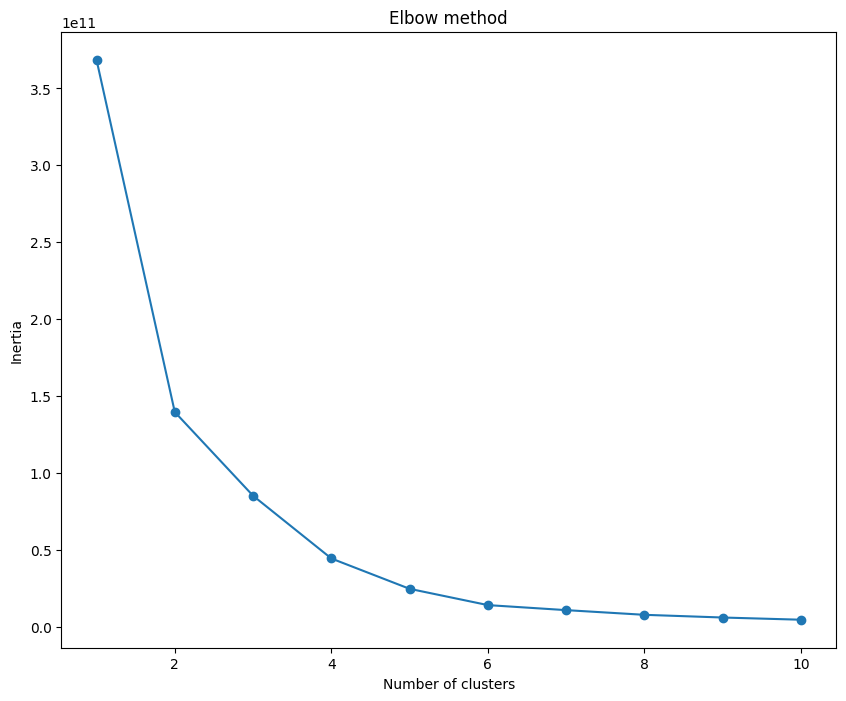

In [180]:
from sklearn.cluster import KMeans

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 


In [185]:
kmeans = KMeans(n_clusters=3)
#kmeans = KMeans(n_clusters=6)
#kmeans = KMeans(n_clusters=4)
#kmeans = KMeans()
kmeans.fit(data)

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3)

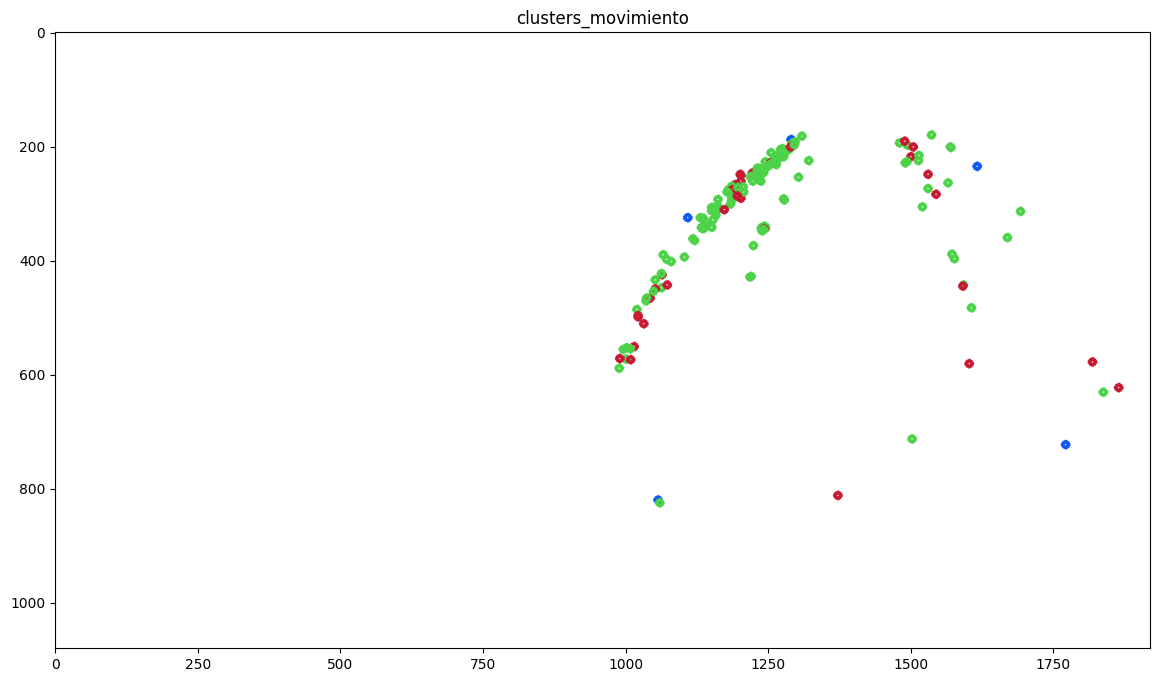

True

In [186]:
size = 10
colors_cluster = dict(zip([i for i in range(size)], [random_color() for i in range(size)]))

fondo = 255*np.ones([height, width, 3], np.uint8)

radius = 5
thickness = 5

for i, (x_center, y_center) in enumerate(all_center):
    predict = kmeans.predict([
        (
            x_center, 
            y_center, 
            all_directions[i],
            all_areas[i]
        )
    ])
    color = colors_cluster[int(predict[0])]

    fondo = cv2.circle(fondo, (x_center, y_center), radius, color, thickness)

plt.figure(figsize=(20,8))
plt.title('clusters_movimiento')
plt.imshow(fondo)
plt.show()

cv2.imwrite("/serverstorage/clusters_movimiento.jpg", fondo)

### vehicles

# Analizando un video de madrid

In [2]:
cap = cv2.VideoCapture('/serverstorage/madrid_6julio2023.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
width, height, layers =  cap.read()[1].shape

height, width, layers, cap.isOpened()

(1280, 720, 3, True)

In [3]:
temp_dir = tempfile.gettempdir()
tmp_path_image = os.path.join(temp_dir, "predict.jpg")

In [4]:
# Define the codec and create VideoWriter object
#out = cv2.VideoWriter('/serverstorage/output.mp4',cv2.VideoWriter_fourcc(*'MP4V'), fps, (height, width))

out = cv2.VideoWriter("/serverstorage/output.avi", cv2.VideoWriter_fourcc(*"MJPG"), fps,(height,width))

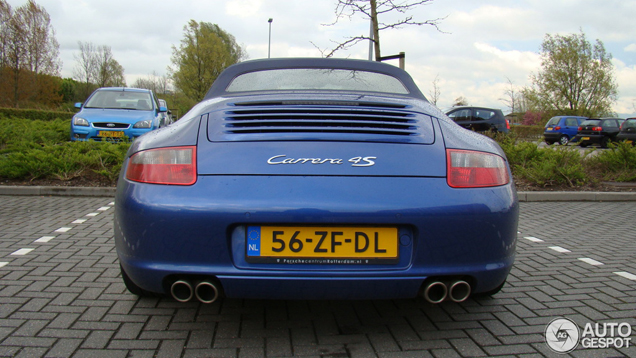

In [5]:
from PIL import Image
Image.open("/data/1.jpg")

In [6]:
class_inference = {0: 'license'}
yolo = YoloPredictor("/yolo_repo", "/yolo_model/car_detection/car_detection.pt", class_inference)

In [7]:
yolo("/data/1.jpg") 

100% 755k/755k [00:00<00:00, 9.75MB/s]


requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.16.201 requires PyYAML<=5.1,>=3.10; python_version != "2.6", but you have pyyaml 6.0 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 701.2/701.2 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.1
    Uninstalling PyYAML-5.1:
      Successfully uninstalled PyYAML-5.1

requirements: urllib3==1.26.11 not found and is required by YOLOv5, attempting auto-update...


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
botocore 1.12.191 requires urllib3<1.26,>=1.20; python_version >= "3.4", but you have urllib3 1.26.11 which is incompatible.
tensorflow 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.20.3 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.25.11
    Uninstalling urllib3-1.25.11:
      Successfully uninstalled urllib3-1.25.11

requirements: wandb not found and is required by YOLOv5, attempting auto-update...



requirements: setuptools==59.5.0 not found and is required by YOLOv5, attempting auto-update...


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.20.3 which is incompatible.
YOLOv5 🚀 2023-6-26 torch 2.0.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4030.4375MB)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.4/952.4 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.6.0
    Uninstalling setuptools-67.6.0:
      Successfully uninstalled setuptools-67.6.0

requirements: 4 packages updated per /yolo_repo/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



Fusing layers... 
Model Summary: 290 layers, 20869098 parameters, 0 gradients
Adding AutoShape... 


AttributeError: 'Upsample' object has no attribute 'recompute_scale_factor'

In [11]:
!pip freeze | grep numpy

ERROR: Error [Errno 2] No such file or directory: 'git' while executing command git config --get-regexp 'remote\..*\.url'
numpy==1.20.3


In [70]:
conteo = 0

while(cap.isOpened()):
    ret, frame = cap.read()
    
    if ret:        
        cv2.imwrite(tmp_path_image, frame)    
        car_predic_orig = yolo(tmp_path_image) 
        car_predic = list(zip(car_predic_orig[0].tolist(), 
                              car_predic_orig[1].tolist(), 
                              car_predic_orig[2].tolist()))
        
        print(car_predic)
        out.write(frame)

        conteo += 1
        if conteo > 10:
            print(conteo)
            break

# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()

100% 755k/755k [00:00<00:00, 3.24MB/s]


requirements: numpy==1.20.3 not found and is required by YOLOv5, attempting auto-update...


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.20.3 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 79.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4

requirements: urllib3==1.26.11 not found and is required by YOLOv5, attempting auto-update...


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
botocore 1.12.191 requires urllib3<1.26,>=1.20; python_version >= "3.4", but you have urllib3 1.26.11 which is incompatible.
awscli 1.16.201 requires PyYAML<=5.1,>=3.10; python_version != "2.6", but you have pyyaml 6.0 which is incompatible.
awscli 1.16.201 requires rsa<=3.5.0,>=3.1.2, but you have rsa 4.7.2 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.25.8
    Uninstalling urllib3-1.25.8:
      Successfully uninstalled urllib3-1.25.8

requirements: setuptools==59.5.0 not found and is required by YOLOv5, attempting auto-update...


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.20.3 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
YOLOv5 🚀 2023-6-26 torch 2.0.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4030.4375MB)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.4/952.4 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.6.0
    Uninstalling setuptools-67.6.0:
      Successfully uninstalled setuptools-67.6.0

requirements: 3 packages updated per /yolo_repo/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



Exception: Cache may be out of date, try `force_reload=True`. See https://github.com/ultralytics/yolov5/issues/36 for help.

In [ ]:
import math
(p, d, q) = (1, 1, 2)math.degrees(math.atan(300/400))